# **Lab 4: Function approximation**
**Christoffer Ejemyr**

# **Abstract**

In this lab we estimate functions i one and two dimentions. Generally it was found that an arbitrarily good approximation can be made, at the expense of computational work and memory load.

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [3]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Christoffer Ejemyr (ejemyr@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [0]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad, dblquad

# **Introduction**

In this lab we will investigate how to approximate functions in a 1d- and 2d-space. This will be done by finding the function $f_{\pi} \in P(I)$ such that $\| f - f_{\pi} \|_{L^2}$ is minimized.

# **Methods**

## Approximation in 1D

Using the algorithm in the lecture notes we itterate over the finite mesh. For each interval we calculate each contribution from the integrals over the interval. In the 1d-case it amounts to 4 integrals from the folowing scalar products: 

$$(\lambda_{k, 0}, \lambda_{k, 0}), (\lambda_{k, 0}, \lambda_{k, 1}), (\lambda_{k, 1}, \lambda_{k, 0}), (\lambda_{k, 1}, \lambda_{k, 1}), $$

all explicitly calculated. Also the scalar products

$$(f, \lambda_{k, 0}), (f, \lambda_{k, 1})$$

are calculated and added to $b$. These are integrated using the `scipy.integrate.quad` method.



In [0]:
def lagrange_poly_1D(x : float, i : int, xk0 : float, xk1 : float, hk : float):
    if i == 0:
        return (xk1 - x) / hk
    elif i == 1:
        return (x - xk0) / hk
    else:
        raise Exception("Index error.")


def L2_projection_1D(f, mesh):
    h = np.diff(mesh)
    b = np.zeros(len(mesh))
    A = np.zeros((len(mesh), len(mesh)))
    for k in range(len(mesh) - 1):
        for i in range(2):
            b[k + i] += quad(lambda x : f(x) * lagrange_poly_1D(x, i, mesh[k], mesh[k + 1], h[k]), mesh[k], mesh[k + 1])[0]
            for j in range(2):
                if i == j:
                    A[k + i, k + j] += h[k] / 3.
                else:
                    A[k + i, k + j] += h[k] / 6.

    return np.linalg.solve(A, b)

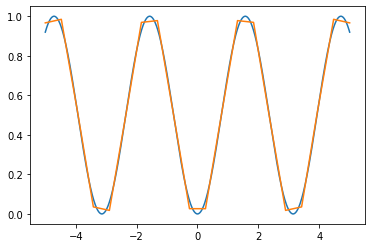

In [20]:
f = lambda x : np.sin(x)**2

x = np.linspace(-5, 5, 1000)
mesh = np.linspace(-5, 5, 20)

alpha = L2_projection_1D(f, mesh)

plt.plot(x, f(x))
plt.plot(mesh, alpha)

## Approximation in 2D

### General
As with the 1D-case we itterate all intervalls, in this case triangular regions in the $(x,y)$-plane.

For each region there are three scalar products between the function $f$ and the lagrangian polynomials $\lambda_{p_k}$, where $\lambda_{p_k}$ is the lagrangian polynomial with its peak at the point $p_k$.

### Lagrangian polynomials
We use the Barycentric coordinate system to define the lagrangian polynomial (plane) over the region contained by the points $p_1, p_2, p_3$. The three polynomials are given by:

$$\lambda_1=\frac{(y_2-y_3)(x-x_3)+(x_3-x_2)(y-y_3)}{(y_2-y_3)(x_1-x_3)+(x_3-x_2)(y_1-y_3)}, $$
$$\lambda_2=\frac{(y_3-y_1)(x-x_3)+(x_1-x_3)(y-y_3)}{(y_2-y_3)(x_1-x_3)+(x_3-x_2)(y_1-y_3)}, $$
$$\lambda_3=1-\lambda_1-\lambda_2,$$

where $(x_i, y_i) = p_i$.

Source: [https://en.wikipedia.org/wiki/Barycentric_coordinate_system](https://en.wikipedia.org/wiki/Barycentric_coordinate_system)


### Integrating over a triangle
To integrate over an arbitrary triangle is not an obvious and easy task. After some research I found a method using coordinate a coordinate change, forcing the region to be the triangle with corners $(0,0), (1,0), (0,1)$.

The coordinate change $(x,y)\rightarrow (u,v)$ is given by

$$(u,v)\mapsto\left\{\eqalign{x(u,v)&=a_1+u(b_1-a_1)+v(c_1-a_1) \cr y(u,v)&=a_2+u(b_2-a_2)+v(c_2-a_2)\ ,\cr}\right.$$

This in turn leads to the following:

$$\int_{S} f(x,y) dS = \int_{0}^{1}\int_{0}^{1 - u} f(x(u, v), y(u, v)) dvdu$$

The right integral can easily be calculated using scipy's function `scipy.integrate.dblquad`.

Source: [https://math.stackexchange.com/questions/954409/double-integral-over-an-arbitrary-triangle](https://math.stackexchange.com/questions/954409/double-integral-over-an-arbitrary-triangle)


In [0]:
def lagrange_poly_2D(p, i, p1, p2, p3):
    if i == 0:
        return ((p2[1] - p3[1])*(p[0] - p3[0]) + (p3[0] - p2[0])*(p[1] - p3[1])) / ((p2[1] - p3[1])*(p1[0] - p3[0]) + (p3[0] - p2[0])*(p1[1] - p3[1]))
    elif i == 1:
        return ((p3[1] - p1[1])*(p[0] - p3[0]) + (p1[0] - p3[0])*(p[1] - p3[1])) / ((p2[1] - p3[1])*(p1[0] - p3[0]) + (p3[0] - p2[0])*(p1[1] - p3[1]))
    elif i == 2:
        return 1. - lagrange_poly_2D(p, 0, p1, p2, p3) - lagrange_poly_2D(p, 1, p1, p2, p3)

def TriagArea(p1, p2, p3):
    return 0.5 * np.linalg.norm( np.cross( p2 - p1, p3 - p1 ) )

def inner_product_lagrange_2D(i, j, area):
    if i == j:
        return area / 12.
    else:
        return area / 6.

def integrate_triangle(f, p1, p2, p3):
    x = lambda u, v : p1[0] + u*(p2[0] - p1[0]) + v*(p3[0] - p1[0])
    y = lambda u, v : p1[1] + u*(p2[1] - p1[1]) + v*(p3[1] - p1[1])

    J_abs = abs((p2[0] - p1[0]) * (p3[1] - p1[1]) - (p3[0] - p1[0]) * (p2[1] - p1[1]))

    return J_abs * dblquad(lambda v, u : f(x(u, v), y(u, v)), 0, 1, lambda x : 0, lambda x : 1 - x)[0]

def L2_projection_2D(f, mesh):
    b = np.zeros(len(mesh.x))
    A = np.zeros((len(mesh.x), len(mesh.x)))
    for k in range(len(mesh.triangles)):
        p1 = np.array([mesh.x[mesh.triangles[k][0]], mesh.y[mesh.triangles[k][0]]])
        p2 = np.array([mesh.x[mesh.triangles[k][1]], mesh.y[mesh.triangles[k][1]]])
        p3 = np.array([mesh.x[mesh.triangles[k][2]], mesh.y[mesh.triangles[k][2]]])
        area = TriagArea(p1, p2, p3)

        for i in range(3):
            peak_ind = mesh.triangles[k][i]
            b[peak_ind] += integrate_triangle(lambda x, y : f(x, y) * lagrange_poly_2D((x, y), i, p1, p2, p3), p1, p2, p3)
            for j in range(i, 3):
                inner_product = integrate_triangle(lambda x, y : lagrange_poly_2D((x, y), j, p1, p2, p3) * lagrange_poly_2D((x, y), i, p1, p2, p3), p1, p2, p3)
                A[peak_ind, mesh.triangles[k][j]] += inner_product
                if i != j:
                    A[mesh.triangles[k][j], peak_ind] += inner_product


    return np.linalg.solve(A, b)

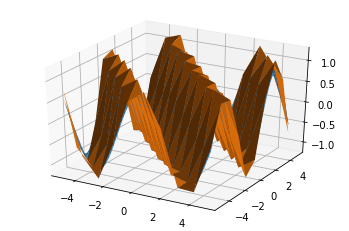

In [21]:
def generate_mesh(lowX, highX, lowY, highY, Nx, Ny):
    hx = (highX - lowX) / (Nx - 1)
    hy = (highY - lowY) / (Ny - 1)
    x = np.zeros((Nx * Ny))
    y = np.zeros((Nx * Ny))
    for i in range(Nx):
        for j in range(Ny):
            x[i * Ny + j] = i * hx + lowX
            y[i * Ny + j] = j * hy + lowY

    return tri.Triangulation(x, y)

def generate_meshgrid(lowX, highX, lowY, highY, Nx, Ny):
    x = np.linspace(lowX, highX, Nx)
    y = np.linspace(lowY, highY, Ny)
    return np.meshgrid(x, y)

lowX = -5
highX = 5
lowY = -5
highY = 5

Nx = 10
Ny = 10
mesh = generate_mesh(lowX, highX, lowY, highY, Nx, Ny)

f = lambda x, y : np.sin(x + y)
alpha = L2_projection_2D(f, mesh)

Nxy_fine = 100
X, Y = generate_meshgrid(lowX, highX, lowY, highY, Nxy_fine, Nxy_fine)
Z = f(X, Y)

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z)
ax.plot_surface(mesh.x.reshape((Nx, Ny)), mesh.y.reshape((Nx, Ny)), alpha.reshape((Nx, Ny)))
plt.show()

# **Results**

One of the most intresting things to examine is the error of the approximation as a function of mesh size. It is desired from a computational standpoint to have a coarse mesh, but this might not meet approximation targets.

To measure the error the norm of the difference between estimation and function was calculated. To make this a measurement not dependent of grid size we divide by the number of grid points.

In [0]:
def get_residual_1D(f, alpha, mesh):
    return np.linalg.norm(f(mesh) - alpha) / len(alpha)
def get_residual_2D(f, alpha, mesh):
    return np.linalg.norm(f(mesh.x, mesh.y) - alpha) / len(alpha)

## 1D Tests

Function $sin^2(x)$ with mesh size 2 gave accuracy 0.27742253322433674
Function $sin^2(x)$ with mesh size 5 gave accuracy 0.1093835061017417
Function $sin^2(x)$ with mesh size 10 gave accuracy 0.052567007420567136
Function $sin^2(x)$ with mesh size 50 gave accuracy 0.0007171763286917718
Function $sin^2(x)$ with mesh size 100 gave accuracy 0.0001233801988185115
Function $sin^2(x)$ with mesh size 500 gave accuracy 2.1653094948691343e-06
Function $sin^2(x)$ with mesh size 1000 gave accuracy 3.8192486201771117e-07
Function $\frac{1}{x + 5.05}$ with mesh size 2 gave accuracy 9.235876613406887
Function $\frac{1}{x + 5.05}$ with mesh size 5 gave accuracy 3.2561593260091257
Function $\frac{1}{x + 5.05}$ with mesh size 10 gave accuracy 1.3833701599606856
Function $\frac{1}{x + 5.05}$ with mesh size 50 gave accuracy 0.12906586047870536
Function $\frac{1}{x + 5.05}$ with mesh size 100 gave accuracy 0.035981217420079925
Function $\frac{1}{x + 5.05}$ with mesh size 500 gave accuracy 0.0009135454090

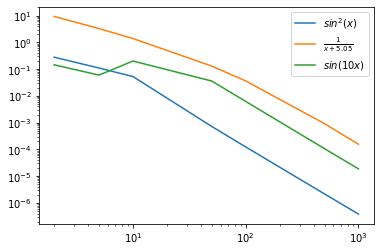

In [19]:
functions = [lambda x : np.sin(x)**2, lambda x : 1./(x + 5.05), lambda x : np.sin(10 * x)]
labels = [r'$sin^2(x)$', r'$\frac{1}{x + 5.05}$', r'$sin(10x)$']
interval_numbers = [2, 5, 10, 50, 100, 500, 1000]

accuracy = np.zeros((len(functions), len(interval_numbers)))
for i, f in enumerate(functions):
    for j, num in enumerate(interval_numbers):
        mesh = np.linspace(-5, 5, num)
        accuracy[i, j] = get_residual_1D(f, L2_projection_1D(f, mesh), mesh)
        print("Function", labels[i], "with mesh size", num, "gave accuracy", accuracy[i, j])

for i, vals in enumerate(accuracy):
    plt.loglog(interval_numbers, vals, label=labels[i])

plt.legend()
plt.show()

## 2D Tests

Function $sin^2(x + y)$ with mesh size 2 x 2 gave accuracy 0.184443240786157
Function $sin^2(x + y)$ with mesh size 5 x 5 gave accuracy 0.0654777836406967
Function $sin^2(x + y)$ with mesh size 7 x 7 gave accuracy 0.04276065096920366
Function $sin^2(x + y)$ with mesh size 10 x 10 gave accuracy 0.024989227351175
Function $sin^2(x + y)$ with mesh size 15 x 15 gave accuracy 0.008565943925999579
Function $\frac{1}{x + y + 5.05}$ with mesh size 2 x 2 gave accuracy 4.900950757132564
Function $\frac{1}{x + y + 5.05}$ with mesh size 5 x 5 gave accuracy 0.7266744353960017
Function $\frac{1}{x + y + 5.05}$ with mesh size 7 x 7 gave accuracy 0.3550837926813382
Function $\frac{1}{x + y + 5.05}$ with mesh size 10 x 10 gave accuracy 0.1635791594427046
Function $\frac{1}{x + y + 5.05}$ with mesh size 15 x 15 gave accuracy 0.06617932071912112
Function $sin(10xy)$ with mesh size 2 x 2 gave accuracy 0.48601239477347735
Function $sin(10xy)$ with mesh size 5 x 5 gave accuracy 0.10755399064019251
Function 

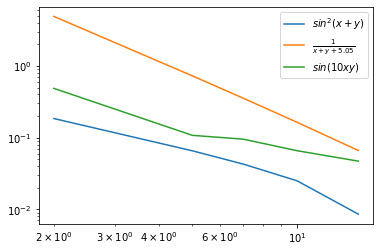

In [17]:
functions = [lambda x, y : np.sin(x + y)**2, lambda x, y : 1./(x + y + 10.05), lambda x, y : np.sin(10 * x * y)]
labels = [r'$sin^2(x + y)$', r'$\frac{1}{x + y + 5.05}$', r'$sin(10xy)$']
interval_numbers = [2, 5, 7, 10, 15]

accuracy = np.zeros((len(functions), len(interval_numbers)))
for i, f in enumerate(functions):
    for j, num in enumerate(interval_numbers):
        mesh = generate_mesh(-5, 5, -5, 5, num, num)
        accuracy[i, j] = get_residual_2D(f, L2_projection_2D(f, mesh), mesh)
        print("Function", labels[i], "with mesh size", num, "x", num, "gave accuracy", accuracy[i, j])

for i, vals in enumerate(accuracy):
    plt.loglog(interval_numbers, vals, label=labels[i])

plt.legend()
plt.show()

# **Discussion**

As expected the error dropped when a finer mesh was used, both in the 1D and 2D examples. This is easy to understand since the mesh can be fitted to adabt better to fast curvature in the function, when finer.

Sadly the pre calculated values of the inner products of the lagrangian functions in two dimensions did not give the desired result, so those were replaced with normal integrals over the mesh triangles resulting in bad time-complexity and absolute time.